In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scipy.io as scio
import numpy as np
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# Data Preprocessing

## 32 data points

In [15]:
inputspath_32 = "/content/drive/My Drive/Colab Notebooks/patch/X_32.csv"
labelspath_32 = "/content/drive/My Drive/Colab Notebooks/patch/y_32.csv"
X_32 = pd.read_csv(inputspath_32)
y_32 = pd.read_csv(labelspath_32)

In [16]:
X_32.shape
y_32.shape

(3340, 1)

In [17]:
data_32 = pd.concat([X_32, y_32], axis=1)
data_32.shape

(3340, 193)

## Training/Testing split

In [18]:
X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split( X_32.values, y_32.values, test_size=0.2, random_state=42 )

scaler = StandardScaler()
X_train_32 = scaler.fit_transform(X_train_32)
X_test_32 = scaler.transform(X_test_32)

In [19]:
print(X_train_32.shape)
print(y_train_32.shape)
print(X_test_32.shape)
print(y_test_32.shape)

(2672, 192)
(2672, 1)
(668, 192)
(668, 1)


# RF-GridSearch

## 32-patch

In [22]:
ave_score_RF_acc = []
ave_score_RF_pre = []
ave_score_RF_rec = []
ave_score_RF_f1 = []

for i in range(10):

  X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split( X_32.values, y_32.values, test_size=0.2)

  scaler=StandardScaler()
  X_train_32=scaler.fit_transform(X_train_32)
  X_test_32=scaler.transform(X_test_32)

  RF = RandomForestClassifier()
  param_grid = { 
            "n_estimators" : [50,100,200,300],
            "max_depth" : [6,8,10],
            "min_samples_leaf" : [2, 4, 6, 8]}
  RF_grid = GridSearchCV(RF, param_grid=param_grid, cv=5)
  RF_grid.fit(X_train_32, y_train_32)
  best_est_RF = RF_grid.best_estimator_

  y_pred = best_est_RF.predict(X_test_32)
  print('Round {}'.format(i))
  print('Best parameters found by grid search are:', RF_grid.best_params_)
  print('Accuracy: {:.2f}%'.format(accuracy_score(y_test_32, y_pred) * 100))
  print('Precision: {:.2f}%'.format(precision_score(y_test_32, y_pred) * 100))
  print('Recall: {:.2f}%'.format(recall_score(y_test_32, y_pred) * 100))
  print('F1_Score: {:.2f}%'.format(f1_score(y_test_32, y_pred) * 100))

  ave_score_RF_acc.append(accuracy_score(y_test_32, y_pred))
  ave_score_RF_pre.append(precision_score(y_test_32, y_pred))
  ave_score_RF_rec.append(recall_score(y_test_32, y_pred))
  ave_score_RF_f1.append(f1_score(y_test_32, y_pred))


Round 0
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300}
Accuracy: 88.77%
Precision: 85.71%
Recall: 87.27%
F1_Score: 86.49%
Round 1
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Accuracy: 88.77%
Precision: 86.76%
Recall: 87.06%
F1_Score: 86.91%
Round 2
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300}
Accuracy: 89.67%
Precision: 87.46%
Recall: 90.07%
F1_Score: 88.74%
Round 3
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300}
Accuracy: 90.72%
Precision: 91.04%
Recall: 87.29%
F1_Score: 89.12%
Round 4
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Accuracy: 90.27%
Precision: 90.04%
Recall: 87.24%
F1_Score: 88.62%
Round 5
Best parameters found by grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators'

In [24]:
print("Accuracy: {}".format(np.mean(ave_score_RF_acc)))
print("Precision: {}".format(np.mean(ave_score_RF_pre)))
print("Recall: {}".format(np.mean(ave_score_RF_rec)))
print("F1_Score: {}".format(np.mean(ave_score_RF_f1)))


Accuracy: 0.8940119760479043
Precision: 0.8830329026615594
Recall: 0.8732742510537704
F1_Score: 0.8779937743314512


# XGBoost - RandomizedSearch

## Hyper-parameter finding

In [10]:
ave_score_XGB_acc = []
ave_score_XGB_pre = []
ave_score_XGB_rec = []
ave_score_XGB_f1 = []


for i in range(10):

  X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split( X_32.values, y_32.values, test_size=0.2)

  scaler=StandardScaler()
  X_train_32=scaler.fit_transform(X_train_32)
  X_test_32=scaler.transform(X_test_32)

  XGB = XGBClassifier(n_jobs=-1, objective = 'binary:logistic') 
  
  param_grid = {
                    'n_estimators'     : [100,150,200,250,300],
                    "learning_rate"    : [0.01, 0.03, 0.10 ],
                    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3 ],
                    "colsample_bytree" : [0.5,0.7],
                    'max_depth'        : [3,4,6,8]
                }
  XGB_grid = RandomizedSearchCV(XGB, param_distributions=param_grid, cv=5)
  XGB_grid.fit(X_train_32,y_train_32)
  best_est_XGB = XGB_grid.best_estimator_

  # y_pred = XGB_grid.predict(X_test_32)
  y_pred = best_est_XGB.predict(X_test_32)
  print('Round {}'.format(i))
  print('Best parameters:', XGB_grid.best_params_)
  print('Accuracy: {:.2f}%'.format(accuracy_score(y_test_32, y_pred) * 100))
  print('Precision: {:.2f}%'.format(precision_score(y_test_32, y_pred) * 100))
  print('Recall: {:.2f}%'.format(recall_score(y_test_32, y_pred) * 100))
  print('F1_Score: {:.2f}%'.format(f1_score(y_test_32, y_pred) * 100))
  print('-----------------------------------------------------------------------------------------------------------------------------')

  ave_score_XGB_acc.append(accuracy_score(y_test_32, y_pred))
  ave_score_XGB_pre.append(precision_score(y_test_32, y_pred))
  ave_score_XGB_rec.append(recall_score(y_test_32, y_pred))
  ave_score_XGB_f1.append(f1_score(y_test_32, y_pred))

Round 0
Best parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
Accuracy: 92.51%
Precision: 92.04%
Recall: 90.78%
F1_Score: 91.41%
-----------------------------------------------------------------------------------------------------------------------------
Round 1
Best parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.5}
Accuracy: 89.82%
Precision: 90.39%
Recall: 86.10%
F1_Score: 88.19%
-----------------------------------------------------------------------------------------------------------------------------
Round 2
Best parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
Accuracy: 91.92%
Precision: 92.91%
Recall: 87.68%
F1_Score: 90.22%
-----------------------------------------------------------------------------------------------------------------------------
Round 3
Best parameters: {'n_estimators': 100,

In [11]:
print(np.mean(ave_score_XGB_acc))

0.9146706586826348


## Formal Test

In [13]:
ave_score_XGB_acc_final = []
ave_score_XGB_pre_final = []
ave_score_XGB_rec_final = []
ave_score_XGB_f1_final = []


for i in range(10):

  X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split( X_32.values, y_32.values, test_size=0.2)

  scaler=StandardScaler()
  X_train_32=scaler.fit_transform(X_train_32)
  X_test_32=scaler.transform(X_test_32)

  XGB = XGBClassifier(n_jobs=-1,n_estimators=300,learning_rate=0.1,gamma=0.2,colsample_bytree=0.6,max_depth=8,objective='binary:logistic') 

  # XGB_grid = RandomizedSearchCV(XGB, param_distributions=param_grid, cv=5)
  # XGB_grid.fit(X_train_32,y_train_32)
  # best_est_XGB = XGB_grid.best_estimator_

  XGB.fit(X_train_32,y_train_32)

  y_pred = XGB.predict(X_test_32)
  print('Round {}'.format(i+1))
  print('Accuracy: {:.2f}%'.format(accuracy_score(y_test_32, y_pred) * 100))
  print('Precision: {:.2f}%'.format(precision_score(y_test_32, y_pred) * 100))
  print('Recall: {:.2f}%'.format(recall_score(y_test_32, y_pred) * 100))
  print('F1_Score: {:.2f}%'.format(f1_score(y_test_32, y_pred) * 100))
  print('----------------------------------------------------------------------------------------------------------------------')

  ave_score_XGB_acc_final.append(accuracy_score(y_test_32, y_pred))
  ave_score_XGB_pre_final.append(precision_score(y_test_32, y_pred))
  ave_score_XGB_rec_final.append(recall_score(y_test_32, y_pred))
  ave_score_XGB_f1_final.append(f1_score(y_test_32, y_pred))

Round 1
Accuracy: 91.92%
Precision: 89.78%
Recall: 90.44%
F1_Score: 90.11%
----------------------------------------------------------------------------------------------------------------------
Round 2
Accuracy: 90.42%
Precision: 90.11%
Recall: 87.63%
F1_Score: 88.85%
----------------------------------------------------------------------------------------------------------------------
Round 3
Accuracy: 90.87%
Precision: 90.18%
Recall: 88.62%
F1_Score: 89.39%
----------------------------------------------------------------------------------------------------------------------
Round 4
Accuracy: 91.77%
Precision: 93.43%
Recall: 87.37%
F1_Score: 90.30%
----------------------------------------------------------------------------------------------------------------------
Round 5
Accuracy: 92.07%
Precision: 91.79%
Recall: 89.55%
F1_Score: 90.65%
----------------------------------------------------------------------------------------------------------------------
Round 6
Accuracy: 91.32%
Preci

In [14]:
print(np.mean(ave_score_XGB_acc_final))

0.9148203592814372


# LightGBM

## 32-patch

In [ ]:
ave_score_LGB_acc = []
ave_score_LGB_pre = []
ave_score_LGB_rec = []
ave_score_LGB_f1 = []


for i in range(10):

  X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split( X_32.values, y_32.values, test_size=0.2, random_state=42 )

  scaler = StandardScaler()
  X_train_32 = scaler.fit_transform(X_train_32)
  X_test_32 = scaler.transform(X_test_32)

  LGB = LGBMClassifier(n_jobs=-1) 
  
  param_grid = {
                    'n_estimators': [300,350,400,450,500],
                    "learning_rate": [0.03,0.10,0.30],
                    "gamma": [0.1,0.2,0.3],
                    'max_depth': [6,8,10,12]
                }
  LGB_grid = RandomizedSearchCV(LGB, param_distributions=param_grid, cv=5)
  LGB_grid.fit(X_train_32,y_train_32)
  best_est_XGB = LGB_grid.best_estimator_

  # print(LGB_grid.best_params_)
  # print(best_est_XGB)

  # print('Accuracy of classifier on training set: {:.2f}'.format(LGB_grid.score(X_train, y_train) * 100))
  y_pred = LGB_grid.predict(X_test_32)
  print('Round {}'.format(i))
  print('Best parameters found by grid search are:', LGB_grid.best_params_)
  print('Accuracy: {:.2f}%'.format(accuracy_score(y_test_32, y_pred) * 100))
  print('Precision: {:.2f}%'.format(precision_score(y_test_32, y_pred) * 100))
  print('Recall: {:.2f}%'.format(recall_score(y_test_32, y_pred) * 100))
  print('F1_Score: {:.2f}%'.format(f1_score(y_test_32, y_pred) * 100))

  ave_score_LGB_acc.append(accuracy_score(y_test_32, y_pred))
  ave_score_LGB_pre.append(precision_score(y_test_32, y_pred))
  ave_score_LGB_rec.append(recall_score(y_test_32, y_pred))
  ave_score_LGB_f1.append(f1_score(y_test_32, y_pred))

Round 0
Best parameters found by grid search are: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2}
Accuracy: 90.12%
Precision: 89.04%
Recall: 88.44%
F1_Score: 88.74%
Round 1
Best parameters found by grid search are: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1}
Accuracy: 90.12%
Precision: 89.04%
Recall: 88.44%
F1_Score: 88.74%
Round 2
Best parameters found by grid search are: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1}
Accuracy: 90.87%
Precision: 89.76%
Recall: 89.46%
F1_Score: 89.61%
Round 3
Best parameters found by grid search are: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1}
Accuracy: 90.87%
Precision: 89.76%
Recall: 89.46%
F1_Score: 89.61%
Round 4
Best parameters found by grid search are: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.2}
Accuracy: 91.77%
Precision: 90.24%
Recall: 91.16%
F1_Score: 90.69%
Round 5
Best parameters found by grid search

In [ ]:
print("Accuracy: {}".format(np.mean(ave_score_LGB_acc)))
print("Precision: {}".format(np.mean(ave_score_LGB_pre)))
print("Recall: {}".format(np.mean(ave_score_LGB_rec)))
print("F1_Score: {}".format(np.mean(ave_score_LGB_f1)))

Accuracy: 0.9056886227544909
Precision: 0.8928488758736082
Recall: 0.8928571428571429
F1_Score: 0.8928334828778326


# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential,activations
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D,Conv2D,MaxPooling1D,MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,Activation,Input,Add,Dense,ZeroPadding2D,Flatten
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.models import Model
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

## Model 1 - Conv1D

In [ ]:
X_train_1 = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_1 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train_1.shape)
print(X_test_1.shape)

(2672, 192, 1)
(668, 192, 1)


In [ ]:
model_1=Sequential()
model_1.add(Conv1D(32,3,activation='relu',input_shape=X_train_1[0].shape,kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_1.add(BatchNormalization())
# model.add(Dropout(0.2))

model_1.add(Conv1D(64,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_1.add(BatchNormalization())
# model.add(Dropout(0.1))

model_1.add(Conv1D(32,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_1.add(BatchNormalization())
# model.add(Dropout(0.1))

model_1.add(Conv1D(16,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_1.add(BatchNormalization())

model_1.add(Flatten())
model_1.add(Dense(16,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
# model.add(Dense(16,activation='relu',kernel_regularizer='l1'))
# model.add(Dropout(0.5))

model_1.add(Dense(1,activation='sigmoid'))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 190, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 190, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 64)           6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 188, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 186, 32)           6176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 186, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 184, 16)           1

In [ ]:
model_1.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=1e-10)
history_1 = model_1.fit(X_train_1,y_train,epochs=50,validation_data=(X_test_1,y_test),callbacks=[reduce_lr_1])

Epoch 1/50
84/84 [==============================] - 2s 20ms/step - loss: 16.9592 - accuracy: 0.7328 - val_loss: 11.0077 - val_accuracy: 0.7635
Epoch 2/50
84/84 [==============================] - 1s 9ms/step - loss: 8.1329 - accuracy: 0.8110 - val_loss: 6.0860 - val_accuracy: 0.5928
Epoch 3/50
84/84 [==============================] - 1s 10ms/step - loss: 4.5300 - accuracy: 0.8147 - val_loss: 3.6544 - val_accuracy: 0.6093
Epoch 4/50
84/84 [==============================] - 1s 9ms/step - loss: 2.8407 - accuracy: 0.8061 - val_loss: 2.5102 - val_accuracy: 0.5853
Epoch 5/50
84/84 [==============================] - 1s 9ms/step - loss: 2.0518 - accuracy: 0.8028 - val_loss: 1.9590 - val_accuracy: 0.8204
Epoch 6/50
84/84 [==============================] - 1s 10ms/step - loss: 1.6183 - accuracy: 0.8151 - val_loss: 1.6150 - val_accuracy: 0.8368
Epoch 7/50
84/84 [==============================] - 1s 10ms/step - loss: 1.3697 - accuracy: 0.8129 - val_loss: 1.3793 - val_accuracy: 0.7829
Epoch 8/50
84/

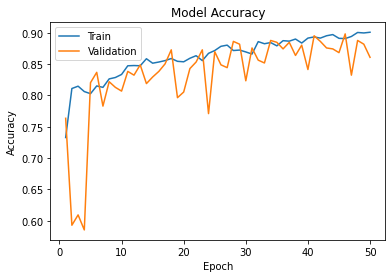

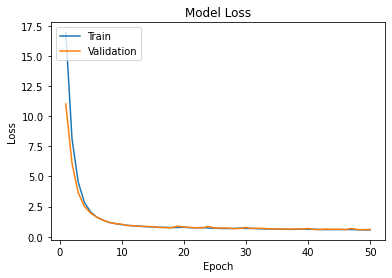

In [ ]:
plotLearningCurve(history_1,50)

## Model 2 - Conv1D

In [ ]:
X_train_2 = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_2 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train_2.shape)
print(X_test_2.shape)

(2672, 192, 1)
(668, 192, 1)


In [ ]:
model_2=Sequential()
model_2.add(Conv1D(32,3,activation='relu',input_shape=X_train_2[0].shape,kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(BatchNormalization())
# model_2.add(MaxPooling1D(pool_size=3,strides=1,padding='same'))

model_2.add(Conv1D(64,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(BatchNormalization())
# model_2.add(MaxPooling1D(pool_size=3,strides=1,padding='same'))

model_2.add(Conv1D(128,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=3,strides=1,padding='same'))

model_2.add(Conv1D(256,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=3,strides=1,padding='same'))

model_2.add(Conv1D(512,3,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=3,strides=1,padding='same'))

model_2.add(Flatten())
model_2.add(Dense(64,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(Dropout(0.1))
model_2.add(Dense(32,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(Dropout(0.1))
model_2.add(Dense(16,activation='relu',kernel_regularizer='l1',kernel_initializer="he_uniform"))
model_2.add(Dense(1,activation='sigmoid'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 190, 32)           128       
_________________________________________________________________
batch_normalization_21 (Batc (None, 190, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 188, 64)           6208      
_________________________________________________________________
batch_normalization_22 (Batc (None, 188, 64)           256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 186, 128)          24704     
_________________________________________________________________
batch_normalization_23 (Batc (None, 186, 128)          512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 186, 128)         

Epoch 1/50
84/84 [==============================] - 2s 26ms/step - loss: 156.1955 - accuracy: 0.5707 - val_loss: 41.1940 - val_accuracy: 0.5584
Epoch 2/50
84/84 [==============================] - 2s 18ms/step - loss: 23.6483 - accuracy: 0.6684 - val_loss: 15.1008 - val_accuracy: 0.5584
Epoch 3/50
84/84 [==============================] - 2s 18ms/step - loss: 12.5750 - accuracy: 0.7358 - val_loss: 11.3366 - val_accuracy: 0.5584
Epoch 4/50
84/84 [==============================] - 2s 18ms/step - loss: 10.6460 - accuracy: 0.7552 - val_loss: 10.3471 - val_accuracy: 0.5584
Epoch 5/50
84/84 [==============================] - 2s 18ms/step - loss: 9.8208 - accuracy: 0.7751 - val_loss: 9.6858 - val_accuracy: 0.5584
Epoch 6/50
84/84 [==============================] - 2s 18ms/step - loss: 9.2659 - accuracy: 0.7751 - val_loss: 9.1932 - val_accuracy: 0.5659
Epoch 7/50
84/84 [==============================] - 2s 18ms/step - loss: 8.8689 - accuracy: 0.7725 - val_loss: 8.8221 - val_accuracy: 0.6931
Epoc

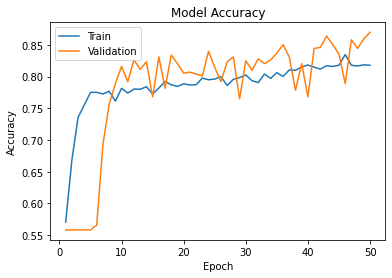

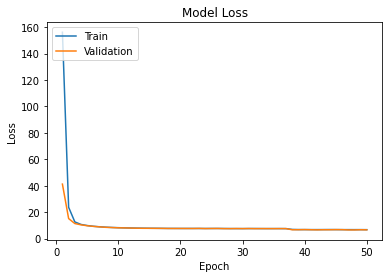

In [ ]:
model_2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=1e-10)
history_2 = model_2.fit(X_train_2,y_train,epochs=50,validation_data=(X_test_2,y_test),callbacks=[reduce_lr_2])
plotLearningCurve(history_2,50)

## Conv2D

In [ ]:
data_2D = np.load("/content/drive/My Drive/Colab Notebooks/patch/data_2D.npz")

X_2D = data_2D["arr_0"]
y_2D = data_2D["arr_1"]

X_2D[np.isnan(X_2D)]=0
y_2D[np.isnan(y_2D)]=0

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_2D, y_2D, test_size=0.2, random_state=42, shuffle=True)

# X_train_3 = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_3 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train_3.shape)
print(X_test_3.shape)


(2672, 32, 32, 1)
(668, 32, 32, 1)


In [ ]:
model_3=Sequential()
model_3.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=X_train_3[0].shape,kernel_regularizer='l2',kernel_initializer="he_uniform",padding="same"))
model_3.add(BatchNormalization())
# model_3.add(MaxPooling2D())

model_3.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform",padding="same"))
model_3.add(BatchNormalization())
# model_3.add(MaxPooling2D())

model_3.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform",padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D())

model_3.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform",padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D())

model_3.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform",padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D())

model_3.add(Flatten())
model_3.add(Dense(64,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_3.add(Dropout(0.2))
model_3.add(Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_3.add(Dropout(0.2))
model_3.add(Dense(16,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
# model.add(Dropout(0.1))
model_3.add(Dense(1,activation='sigmoid'))


model_3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_90 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_91 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_92 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 64)      

In [ ]:
model_3.compile(optimizer=Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=1e-10)
history_3 = model_3.fit(X_train_3,y_train_3,epochs=50,validation_data=(X_test_3,y_test_3),callbacks=[reduce_lr_3])


Epoch 1/50
84/84 [==============================] - 1s 11ms/step - loss: 12.1103 - accuracy: 0.5240 - val_loss: 11.0165 - val_accuracy: 0.5868
Epoch 2/50
84/84 [==============================] - 1s 8ms/step - loss: 10.0388 - accuracy: 0.5573 - val_loss: 9.0895 - val_accuracy: 0.6287
Epoch 3/50
84/84 [==============================] - 1s 8ms/step - loss: 8.2534 - accuracy: 0.5865 - val_loss: 7.4493 - val_accuracy: 0.6377
Epoch 4/50
84/84 [==============================] - 1s 8ms/step - loss: 6.7984 - accuracy: 0.6156 - val_loss: 6.1637 - val_accuracy: 0.6407
Epoch 5/50
84/84 [==============================] - 1s 8ms/step - loss: 5.6479 - accuracy: 0.6504 - val_loss: 5.1881 - val_accuracy: 0.5943
Epoch 6/50
84/84 [==============================] - 1s 8ms/step - loss: 4.7625 - accuracy: 0.6785 - val_loss: 4.4229 - val_accuracy: 0.6317
Epoch 7/50
84/84 [==============================] - 1s 8ms/step - loss: 4.0788 - accuracy: 0.7002 - val_loss: 3.8761 - val_accuracy: 0.6407
Epoch 8/50
84/84

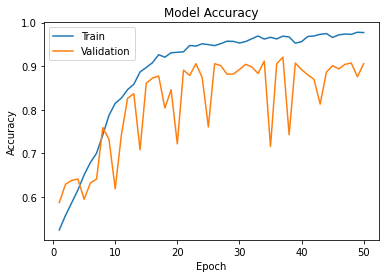

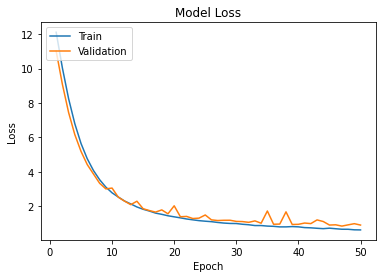

In [ ]:
plotLearningCurve(history_3,50)

# ResNet

In [ ]:
def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def ResNet50(input_shape = (32, 32, 1), classes = 1):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (7, 7), strides = (2,2), padding = 'same', name = 'conv1', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2,2), padding = 'same')(X)
 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [64,64,256], stage=2, block='b')
    X = identity_block(X, 3, [64,64,256], stage=2, block='c')
 
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')
 
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
    X = AveragePooling2D((2, 2), name='avg_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    X = Dense(classes, activation = 'sigmoid', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
 
    return model

In [ ]:
model_4 = ResNet50(input_shape = (32, 32, 1), classes = 1)
model_4.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
reduce_lr_4 = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=1e-10)
history_4 = model_4.fit(X_train_3,y_train_3,epochs=50,validation_data=(X_test_3,y_test_3),callbacks=[reduce_lr_4])

Epoch 1/50
84/84 [==============================] - 5s 54ms/step - loss: 3985.5710 - accuracy: 0.5614 - val_loss: 3455.4761 - val_accuracy: 0.5599
Epoch 2/50
84/84 [==============================] - 4s 43ms/step - loss: 3016.7573 - accuracy: 0.5928 - val_loss: 2602.3311 - val_accuracy: 0.6362
Epoch 3/50
84/84 [==============================] - 4s 43ms/step - loss: 2281.6965 - accuracy: 0.6381 - val_loss: 1991.5327 - val_accuracy: 0.5958
Epoch 4/50
84/84 [==============================] - 4s 43ms/step - loss: 1767.8463 - accuracy: 0.6868 - val_loss: 1550.7985 - val_accuracy: 0.5584
Epoch 5/50
84/84 [==============================] - 4s 43ms/step - loss: 1369.5345 - accuracy: 0.7062 - val_loss: 1196.8821 - val_accuracy: 0.5584
Epoch 6/50
84/84 [==============================] - 4s 43ms/step - loss: 1058.2147 - accuracy: 0.7369 - val_loss: 929.1032 - val_accuracy: 0.5958
Epoch 7/50
84/84 [==============================] - 4s 43ms/step - loss: 830.2629 - accuracy: 0.7305 - val_loss: 739.29

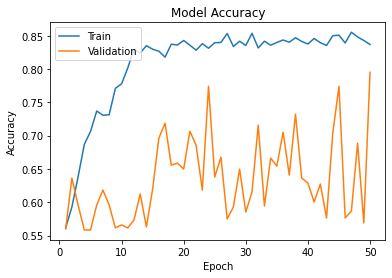

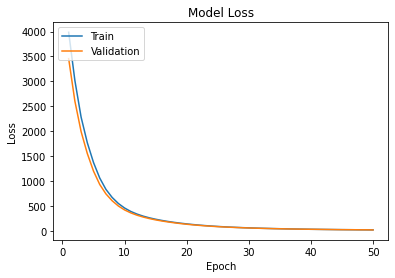

In [ ]:
plotLearningCurve(history_4,50)